# GradCAM Visualization Demo with VGG16


In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import skimage.io
import numpy as np
from model import vgg16
from matplotlib import pyplot as plt
from skimage.transform import resize
import cv2

In [2]:
# Replace vanila relu to guided relu to get guided backpropagation.
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    #return tf.where(0. < grad, gen_nn_ops.relu_grad(grad, op.outputs[0]), tf.zeros(grad.get_shape()))
    gate_f = tf.cast(op.outputs[0] > 0, "float32") #for f^l > 0 , it will return 0 if output > 0 which will be casted to float 1.0 else 0.0
    gate_R = tf.cast(grad > 0, "float32") #for R^l+1 > 0 , it will return 0 if grad is > 0 which will be casted to float 1.0 else 0.0
    return gate_f * gate_R * grad

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def load_image(path, normalize=True):
    """
    args:
        normalize: set True to get pixel value of 0~1
    """
    # load image
    img = skimage.io.imread(path)
    if normalize:
        img = img / 255.0
        assert (0 <= img).all() and (img <= 1.0).all()


    # print "Original Image Shape: ", img.shape
    # we crop image from center
    short_edge = min(img.shape[:2])
    yy = int((img.shape[0] - short_edge) / 2)
    xx = int((img.shape[1] - short_edge) / 2)
    crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    # resize to 224, 224
    resized_img = resize(crop_img, (224, 224), preserve_range=True) # do not normalize at transform. 
    return resized_img

def visualize(image, conv_output, conv_grad, gb_viz):
    # conv_output  [7,7,512]
    # conv_grad    [7,7,512]
    print("grads_val shape:", conv_grad.shape)
    print("gb_viz shape:", gb_viz.shape)

    weights = np.mean(conv_grad, axis = (0, 1)) # alpha_k, [512]
    
    print(weights.shape , "weights shape")
    cam = np.zeros(conv_output.shape[0 : 2], dtype = np.float32)	# [7,7]
    print(cam.shape , "CAM Shape")

    # Taking a weighted average of the convolutional output (CAM)
    for i, w in enumerate(weights):
        cam += w * conv_output[:, :, i]

    # Passing through ReLU
    cam = np.maximum(cam, 0)
    cam = cam / np.max(cam) # scale 0 to 1.0
    cam = resize(cam, (224,224), preserve_range=True)

    cam_heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    cam_heatmap = cv2.cvtColor(cam_heatmap, cv2.COLOR_BGR2RGB)
    
    fig = plt.figure()    
    ax = fig.add_subplot(111)
    imgplot = plt.imshow(image)
    ax.set_title('Input Image')
    
    fig = plt.figure(figsize=(12, 16))    
    ax = fig.add_subplot(131)
    imgplot = plt.imshow(cam_heatmap)
    ax.set_title('Grad-CAM')   
    
    # Guided Gradients
    
    gb_viz = np.dstack((
            gb_viz[:, :, 0],
            gb_viz[:, :, 1],
            gb_viz[:, :, 2],
        ))       
    gb_viz -= np.min(gb_viz)
    gb_viz /= gb_viz.max()

    ax = fig.add_subplot(132)
    imgplot = plt.imshow(gb_viz)
    ax.set_title('guided backpropagation')
    
    # Guided Gradient * CAM

    gd_gb = np.dstack((
            gb_viz[:, :, 0] * cam,
            gb_viz[:, :, 1] * cam,
            gb_viz[:, :, 2] * cam,
        ))            
    ax = fig.add_subplot(133)
    imgplot = plt.imshow(gd_gb)
    ax.set_title('guided Grad-CAM')

    plt.show()
    


/Users/chinesh.doshi/Desktop/chinesh/Machine Learning/Grad-CAM-tensorflow-master/model/vgg16.npy
dict_keys(['conv5_1', 'fc6', 'conv5_3', 'conv5_2', 'fc8', 'fc7', 'conv4_1', 'conv4_2', 'conv4_3', 'conv3_3', 'conv3_2', 'conv3_1', 'conv1_1', 'conv1_2', 'conv2_2', 'conv2_1'])
npy file loaded
build model started
build model finished: 3s
cost: Tensor("mul_2:0", shape=(1,), dtype=float32)
y_c: Tensor("Sum_1:0", shape=(1,), dtype=float32)
(1, 224, 224, 3)
(1, 7, 7, 512)
(1, 7, 7, 512)
grads_val shape: (7, 7, 512)
gb_viz shape: (224, 224, 3)
(512,) weights shape
(7, 7) CAM Shape


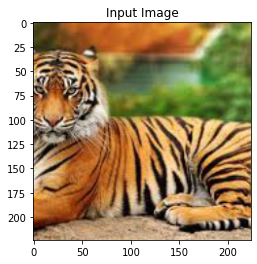

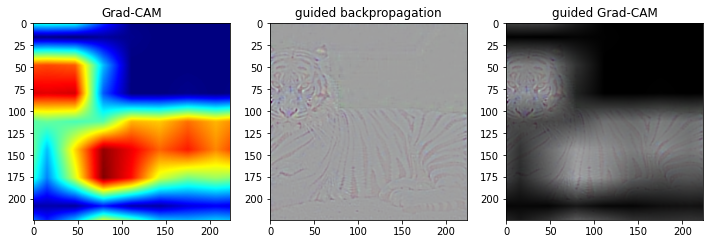

In [4]:
# Get normalized input. VGG network handles the normalized image internally. 
img1 = load_image("./tiger.jpg")   # read image-> normalize -> crop -> resize

batch_img = img1.reshape((1, 224, 224, 3))
batch_label = np.array([1 if i == 242 else 0 for i in range(1000)])  # 1-hot result for Dog
batch_label = batch_label.reshape(1, -1)

# batch_size = 1

# Create tensorflow graph for evaluation
eval_graph = tf.Graph()
with eval_graph.as_default():
    with eval_graph.gradient_override_map({'Relu': 'GuidedRelu'}):
        images = tf.placeholder("float", [1, 224, 224, 3])
        labels = tf.placeholder(tf.float32, [1, 1000])
        # Initialize the model
        vgg = vgg16.Vgg16()
        # Run the model on the input image so that we can get the required values for creating the Grad-CAM
        vgg.build(images)
        
        cost = (-1) * tf.reduce_sum(tf.multiply(labels, tf.log(vgg.prob)), axis=1)
        print('cost:', cost)
        
        # gradient for partial linearization. We only care about target visualization class. 
        y_c = tf.reduce_sum(tf.multiply(vgg.fc8, labels), axis=1)
        print('y_c:', y_c)
        
        # Get last convolutional layer gradient for generating gradCAM visualization
        target_conv_layer = vgg.pool5
        target_conv_layer_grad = tf.gradients(y_c, target_conv_layer)[0]

        # Guided backpropagtion back to input layer
        gb_grad = tf.gradients(cost, images)[0]

        init = tf.global_variables_initializer()

        
# Run tensorflow 

with tf.Session(graph=eval_graph) as sess:    
    sess.run(init)
    gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad], feed_dict={images: batch_img, labels: batch_label}) 
                                                                           #  sess.run(fetches, feed_dict=None, options=None, run_metadata=None)
    
    print(gb_grad_value.shape)
    print(target_conv_layer_grad_value.shape)
    print(target_conv_layer_value.shape)
    # VGG16 use BGR internally, so we manually change BGR to RGB
    gradBGR = gb_grad_value[0]
    
    # BGR to RGB conversion
    gradRGB = np.dstack((
        gradBGR[:, :, 2],
        gradBGR[:, :, 1],
        gradBGR[:, :, 0],
    ))
    visualize(batch_img[0], target_conv_layer_value[0], target_conv_layer_grad_value[0], gradRGB)
    